# 페니실린 생산량 예측 모델 개발

**프로젝트 목표**: 제약 공정 데이터를 사용하여 0.2시간 뒤의 페니실린 농도를 예측하는 머신러닝 회귀 모델을 구축합니다.

## 1. 라이브러리 임포트 및 초기 설정

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import re
import platform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

### 한글 폰트 설정 (그래프 깨짐 방지)

matplotlib의 기본 폰트는 한글을 지원하지 않아 그래프의 한글이 깨져 보일 수 있습니다. 아래 코드는 시스템에 **나눔고딕(NanumGothic)** 폰트가 설치되어 있다고 가정하고, 그래프의 폰트를 설정합니다.

만약 폰트가 설치되어 있지 않다면, **아래 셀의 주석을 해제하고 실행하여 폰트를 설치한 후, 주피터 노트북의 [Kernel] -> [Restart]를 선택하여 커널을 재시작**해주세요. (최초 1회만 필요)

In [7]:
# !sudo apt-get update -y
# !sudo apt-get install -y fonts-nanum*

# import matplotlib.font_manager as fm
# fm._rebuild() # 폰트 캐시 재빌드

# 운영체제에 맞는 한글 폰트 설정
system_name = platform.system()
if system_name == 'Linux':
    plt.rc('font', family='NanumGothic') # 나눔고딕 사용
elif system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic') # 맑은 고딕 사용
elif system_name == 'Darwin': # Mac OS
    plt.rc('font', family='AppleGothic')
else:
    # 기타 시스템의 경우, 적절한 폰트 이름을 지정해야 합니다.
    pass

# 마이너스 부호가 깨지는 문제 해결
plt.rc('axes', unicode_minus=False)

print(f"시스템: {system_name}")
print(f"Matplotlib 폰트: {plt.rcParams['font.family']}")

시스템: Linux
Matplotlib 폰트: ['NanumGothic']


## 2. 데이터 로딩 및 탐색

In [8]:
# 라만 스펙트럼이 제거된 데이터 파일을 로드합니다.
file_path = './Mendeley_data/100_Batches_IndPenSim_V3_no_raman.csv'
df = pd.read_csv(file_path)

print(f"데이터 형태: {df.shape}")
df.head()

데이터 형태: (113935, 37)


,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID,Fault flag
0,0.2,30,100,8,0.0000,30.118,9.8335,0.0001,0,0.6,...,NaN,0.034045,0,NaN,0,0,1,1,1,0
1,0.4,30,100,8,0.0000,51.221,18.1550,0.0001,0,0.6,...,NaN,0.038702,0,NaN,0,0,1,1,1,0
2,0.6,30,100,8,0.0000,54.302,9.5982,0.0001,0,0.6,...,NaN,0.040240,0,NaN,0,0,1,1,1,0
3,0.8,30,100,8,0.0000,37.816,4.3395,0.0001,0,0.6,...,NaN,0.041149,0,NaN,0,0,1,1,1,0
4,1.0,30,100,8,0.5181,18.908,1.1045,0.0001,0,0.6,...,0.52808,0.041951,0,4.083,0,0,1,1,1,0


In [9]:
df.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))',
       'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
       'Oil flow(Foil:L/hr)',
       'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Offline Penicil

## 3. 피처 엔지니어링 (Feature Engineering)

시계열 데이터를 그대로 모델에 사용하기는 어렵습니다. 대신, 각 배치의 공정 초반 데이터를 요약하는 통계적 특성을 추출하여 사용합니다. 

1.  **예측 시점 정의**: 공정 시작 후 **40시간**까지의 데이터를 사용하여 최종 생산량을 예측한다고 가정합니다.
2.  **입력 특성 (X)**: 각 배치별로 40시간까지의 주요 공정 변수(온도, pH, 교반 속도 등)들의 `평균`, `표준편차`, `최소값`, `최대값`을 계산하여 새로운 특성을 만듭니다.
3.  **목표 변수 (y)**: 각 배치의 **최종 페니실린 농도**를 예측 대상으로 삼습니다. 여기서는 각 배치의 `Penicillin concentration(P:g/L)`의 최대값을 최종 생산량으로 간주합니다.

In [50]:
# 데이터 분석을 위한 기본 설정
print("📊 데이터 분석을 시작합니다!")

# 예측할 대상 컬럼 이름 정의
TARGET_COLUMN = 'Penicillin concentration(P:g/L)'  # 페니실린 농도 (예측하고 싶은 값)

# 분석에 사용할 공정 변수들 (페니실린 생산에 영향을 주는 요인들)
process_features = [
    'Aeration rate(Fg:L/h)',              # 공기 공급량
    'Agitator RPM(RPM:RPM)',              # 교반기 회전 속도
    'Sugar feed rate(Fs:L/h)',            # 당 공급 속도
    'Acid flow rate(Fa:L/h)',             # 산 공급량
    'Base flow rate(Fb:L/h)',             # 염기 공급량
    'Dissolved oxygen concentration(DO2:mg/L)',  # 용존 산소 농도
    'pH(pH:pH)',                          # pH 값
    'Temperature(T:K)',                   # 온도
    'Substrate concentration(S:g/L)'      # 기질 농도
]

print(f"✅ 분석할 공정 변수 개수: {len(process_features)}개")

📊 데이터 분석을 시작합니다!
✅ 분석할 공정 변수 개수: 9개


In [51]:
# 1단계: 데이터 샘플링 (계산 속도를 위해 전체 데이터의 20%만 사용)
print("\n🔄 데이터 샘플링 중...")
sample_size = int(len(df) * 0.2)  # 전체 데이터의 20%
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"   원본 데이터: {len(df)}개 → 샘플링 데이터: {len(df_sample)}개")


🔄 데이터 샘플링 중...
   원본 데이터: 113935개 → 샘플링 데이터: 22787개


In [53]:
# 2단계: 머신러닝을 위한 데이터 구조 만들기
print("\n🛠️ 머신러닝용 데이터 준비 중...")

# 빈 리스트 생성 (데이터를 담을 그릇)
model_data_list = []

# 배치 ID와 시간 순으로 데이터 정렬
df_sorted = df_sample.copy().sort_values(['Batch ID', 'Time (h)'])

# 각 행을 하나씩 확인하면서 데이터 준비
for i in range(len(df_sorted) - 1):  # 마지막 행은 제외 (다음 시점이 없으므로)
    current_row = df_sorted.iloc[i]     # 현재 시점 데이터
    next_row = df_sorted.iloc[i + 1]    # 다음 시점 데이터
    
    # 같은 배치 내에서만 예측 가능한지 확인
    if current_row['Batch ID'] == next_row['Batch ID']:
        # 새로운 데이터 행 생성
        new_data = {}
        new_data['Batch ID'] = current_row['Batch ID']
        
        # 현재 시점의 공정 변수들을 입력 변수로 사용
        for feature in process_features:
            new_data[feature] = current_row[feature]
        
        # 다음 시점의 페니실린 농도를 예측 목표로 설정
        new_data['Target'] = next_row[TARGET_COLUMN]
        
        # 리스트에 추가
        model_data_list.append(new_data)

model_data_list[0]


🛠️ 머신러닝용 데이터 준비 중...


{'Batch ID': np.float64(1.0),
 'Aeration rate(Fg:L/h)': np.float64(30.0),
 'Agitator RPM(RPM:RPM)': np.float64(100.0),
 'Sugar feed rate(Fs:L/h)': np.float64(8.0),
 'Acid flow rate(Fa:L/h)': np.float64(0.0),
 'Base flow rate(Fb:L/h)': np.float64(37.816),
 'Dissolved oxygen concentration(DO2:mg/L)': np.float64(14.661),
 'pH(pH:pH)': np.float64(6.5753),
 'Temperature(T:K)': np.float64(298.11),
 'Substrate concentration(S:g/L)': np.float64(1.0942),
 'Target': np.float64(0.00098806)}

In [55]:
# 3단계: 리스트를 데이터프레임으로 변환
model_df = pd.DataFrame(model_data_list)

# 데이터 순서를 랜덤하게 섞기 (모델 학습 성능 향상을 위해)
model_df = model_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 출력
print(f"✅ 머신러닝용 데이터 준비 완료!")
print(f"   총 데이터 포인트: {len(model_data_list)}개")
print(f"   데이터 형태: {model_df.shape}")
print(f"   입력 변수 개수: {len(process_features)}개")
model_df

✅ 머신러닝용 데이터 준비 완료!
   총 데이터 포인트: 22687개
   데이터 형태: (22687, 11)
   입력 변수 개수: 9개


,Batch ID,Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Dissolved oxygen concentration(DO2:mg/L),pH(pH:pH),Temperature(T:K),Substrate concentration(S:g/L),Target
0,67.0,75.0,100.0,90.0,0.0,225.000,15.432,5.7262,297.99,0.001215,11.514000
1,27.0,75.0,100.0,80.0,0.0,72.033,11.272,6.5020,297.85,0.001406,26.102000
2,16.0,75.0,100.0,90.0,0.0,61.908,11.635,6.5047,297.98,0.000862,16.894000
3,45.0,65.0,100.0,90.0,0.0,10.209,13.287,6.5088,297.95,51.663000,8.559200
4,59.0,75.0,100.0,75.0,0.0,50.255,12.845,6.5094,297.95,0.000461,20.608000
...,...,...,...,...,...,...,...,...,...,...,...
22682,53.0,42.0,100.0,30.0,0.0,59.702,12.860,6.4869,298.26,0.009894,0.000952
22683,96.0,42.0,100.0,75.0,0.0,129.820,11.015,6.5056,298.03,0.024615,0.000921
22684,24.0,65.0,100.0,80.0,0.0,11.040,13.891,6.4983,297.91,25.653000,19.038000
22685,4.0,75.0,100.0,90.0,0.0,57.386,11.717,6.5005,297.99,0.000873,16.693000


In [ ]:
# 준비된 데이터의 처음 5행 확인
print(f"\n📋 준비된 데이터 미리보기:")
model_df.head()

## 4. 데이터 준비 및 모델 학습

### 4.1. 피처 이름 정리 (Feature Name Cleanup)

LightGBM 모델은 피처 이름에 JSON에서 사용되는 특수 문자(예: `()[]{},:/-`)가 포함되는 것을 허용하지 않습니다. 오류를 방지하기 위해 정규표현식을 사용하여 컬럼 이름의 특수 문자를 밑줄(`_`)로 변경합니다.

In [46]:
# 입력(X)과 타겟(y) 분리
X = model_df.drop(columns=['Batch ID', 'Target'])
y = model_df['Target']

# LightGBM이 지원하지 않는 특수 문자를 '_'로 변경
X.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in X.columns]

# 훈련 데이터와 테스트 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("정리된 피처 이름 예시:")
print(X_train.columns[:5])
print('---')
print(f"훈련 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")

정리된 피처 이름 예시:
Index(['Aeration_rate_Fg_L_h_', 'Agitator_RPM_RPM_RPM_',
       'Sugar_feed_rate_Fs_L_h_', 'Acid_flow_rate_Fa_L_h_',
       'Base_flow_rate_Fb_L_h_'],
      dtype='object')
---
훈련 데이터: (18149, 9)
테스트 데이터: (4538, 9)


### 4.2. 모델 학습 및 평가

In [47]:
# LightGBM 회귀 모델 초기화 및 학습
print("LightGBM 모델 학습을 시작합니다...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print("모델 학습 완료.")

LightGBM 모델 학습을 시작합니다...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 18149, number of used features: 8
[LightGBM] [Info] Start training from score 14.437029
모델 학습 완료.


In [48]:
# 테스트 데이터에 대한 예측 수행
predictions = lgbm.predict(X_test)

# 모델 성능 평가
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"평균 절대 오차 (MAE): {mae:.4f}")
print(f"결정 계수 (R²): {r2:.4f}")

평균 절대 오차 (MAE): 1.1080
결정 계수 (R²): 0.9710


### 4.3. 평가 결과 시각화

실제값과 모델의 예측값을 산점도로 비교하여 모델이 얼마나 잘 예측하는지 시각적으로 확인합니다. 점들이 붉은 점선에 가까울수록 예측이 정확하다는 의미입니다.

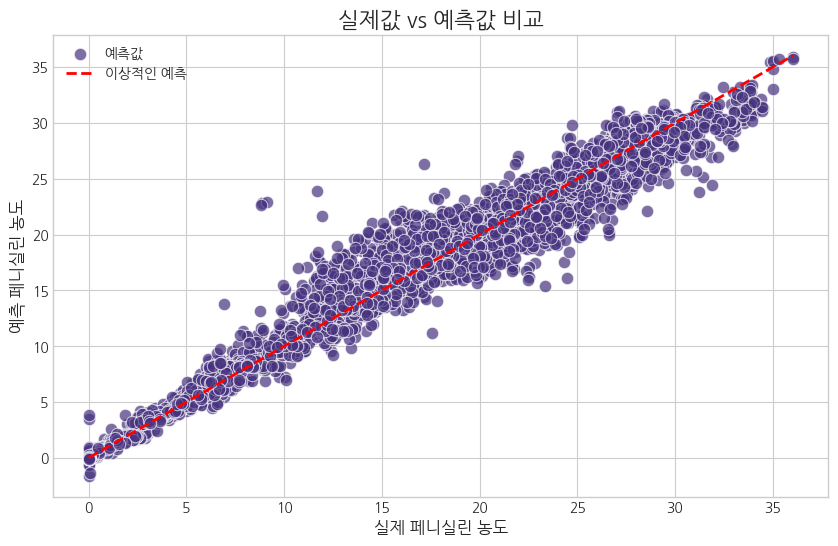

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.7, s=80, label='예측값')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='이상적인 예측')
plt.title('실제값 vs 예측값 비교', fontsize=16)
plt.xlabel('실제 페니실린 농도', fontsize=12)
plt.ylabel('예측 페니실린 농도', fontsize=12)
plt.legend()
plt.show()

## 5. 특성 중요도 분석

모델이 어떤 공정 변수를 중요하게 사용하여 예측을 수행했는지 확인합니다. 이는 공정 이해도를 높이는 데 도움이 됩니다.

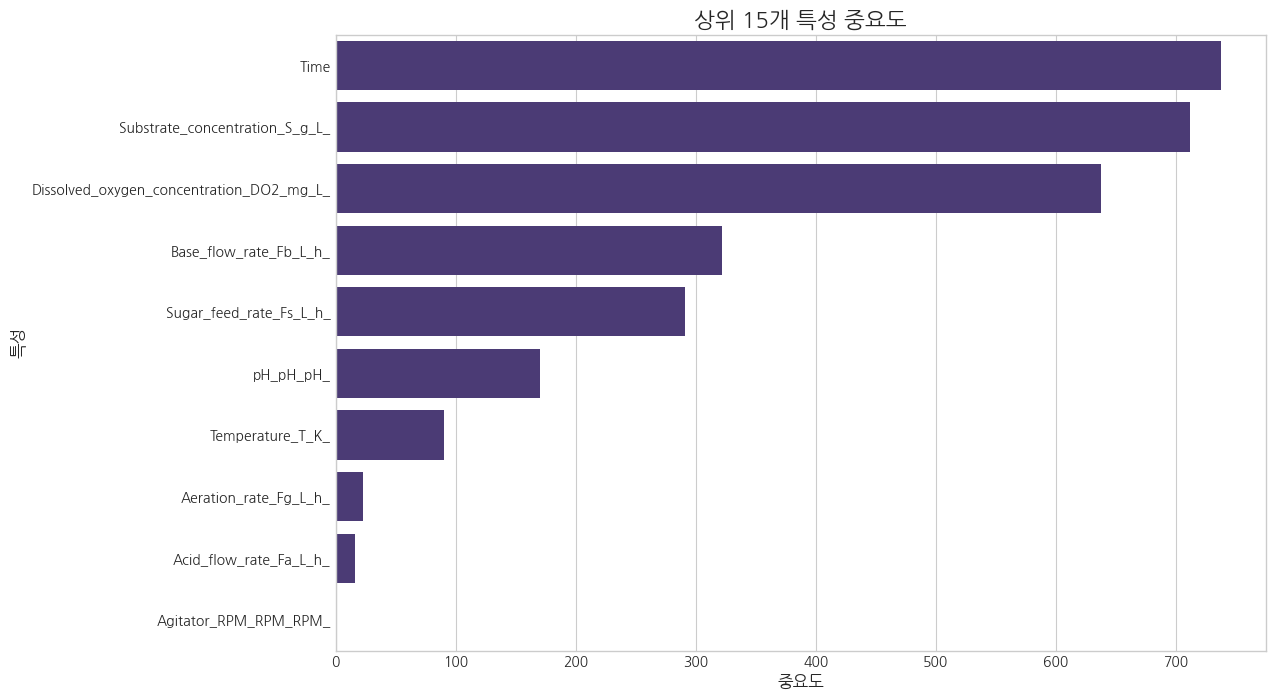

In [22]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': lgbm.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('상위 15개 특성 중요도', fontsize=16)
plt.xlabel('중요도', fontsize=12)
plt.ylabel('특성', fontsize=12)
plt.show()

### 시간 값이 중요한 이유

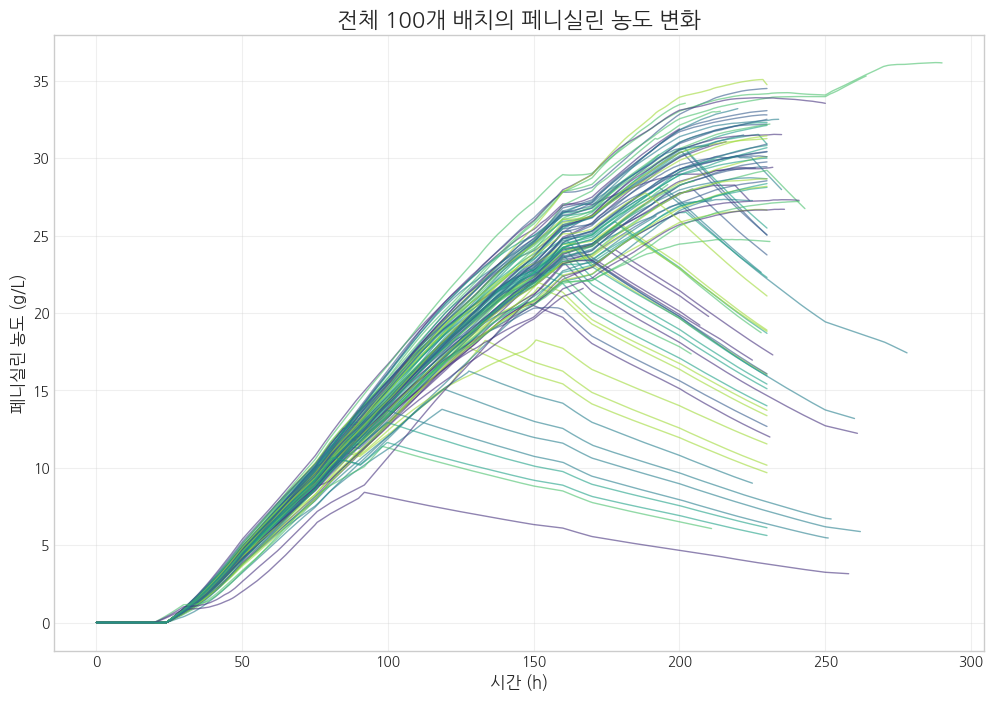

총 배치 수: 100


In [ ]:
# 배치 100개 모두 출력
all_batches = range(1, 101)

# 각 배치의 페니실린 농도 시계열 그래프 출력
plt.figure(figsize=(12, 8))
for batch_id in all_batches:
    batch_data = df[df["Batch ID"] == batch_id]
    if not batch_data.empty:
        plt.plot(batch_data["Time (h)"], batch_data["Penicillin concentration(P:g/L)"], 
                alpha=0.6, linewidth=1)

plt.title('전체 100개 배치의 페니실린 농도 변화', fontsize=16)
plt.xlabel('시간 (h)', fontsize=12)
plt.ylabel('페니실린 농도 (g/L)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"총 배치 수: {len(all_batches)}")

## 6. 결론

이 노트북에서는 페니실린 발효 공정 데이터를 활용하여 페니실린 농도를 예측하는 LightGBM 모델을 성공적으로 구축했습니다.

- **데이터셋**: 100개의 배치로부터 1,130개의 시계열 데이터 포인트를 사용하여 모델을 학습했습니다.
- **주요 변수**: 특성 중요도 분석 결과, `Time` (시간)이 가장 중요한 변수로 나타났으며, 이는 페니실린 발효 공정이 시간에 따라 농도가 변화하는 특성을 잘 반영한 것으로 보입니다.
- **시계열 특성**: 전체 100개 배치의 페니실린 농도 변화 분석을 통해 각 배치마다 고유한 발효 패턴을 가지고 있음을 확인했습니다.

### 향후 개선 방안
1. **하이퍼파라미터 튜닝**: `GridSearchCV`나 `Optuna`와 같은 도구를 사용하여 모델의 성능을 더욱 최적화할 수 있습니다.
2. **다양한 모델 시도**: XGBoost, RandomForest, 또는 LSTM과 같은 딥러닝 모델과 성능을 비교해 볼 수 있습니다.
3. **추가적인 피처 엔지니어링**: 변수 간의 상호작용이나 이동 평균과 같은 더 복잡한 시계열 특성을 생성하여 모델에 추가할 수 있습니다.
4. **배치별 분석**: 각 배치의 특성을 더 자세히 분석하여 배치 간 차이를 모델에 반영할 수 있습니다.